In [ ]:
!pip install nixtlats

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_percentage_error
import math
import numpy as np

In [ ]:
!unzip chick.zip

In [ ]:
!unzip /content/drive/MyDrive/pjm.zip

### Prediction

#### Mackey-glass dataset


In [ ]:
from sklearn.preprocessing import MinMaxScaler

def prepare_mg(mg):
    mg['date'] = pd.date_range(start="01-01-2000", periods=mg.shape[0], freq="D")
    mg_train = mg[mg.date.dt.year<2020]
    mg_val = mg[mg.date.dt.year>=2020]
    columns_to_normalize = ['y']
    scaler = MinMaxScaler()
    mg_train[columns_to_normalize] = scaler.fit_transform(mg_train[columns_to_normalize].values)
    mg_val[columns_to_normalize] = scaler.transform(mg_val[columns_to_normalize].values)

    mg[columns_to_normalize] = scaler.fit_transform(mg[columns_to_normalize].values)

    return mg_train, mg_val, mg

In [ ]:
mg = pd.read_csv('mg.csv')

mg_train, mg_val, mg = prepare_mg(mg)

In [ ]:
mg.head()

,y,date
0,0.896060,2000-01-01
1,0.885151,2000-01-02
2,0.874351,2000-01-03
3,0.863658,2000-01-04
4,0.853071,2000-01-05


In [ ]:
from nixtlats import TimeGPT

In [ ]:
timegpt = TimeGPT(
    # defaults to os.environ.get("TIMEGPT_TOKEN")
    token = ''
)

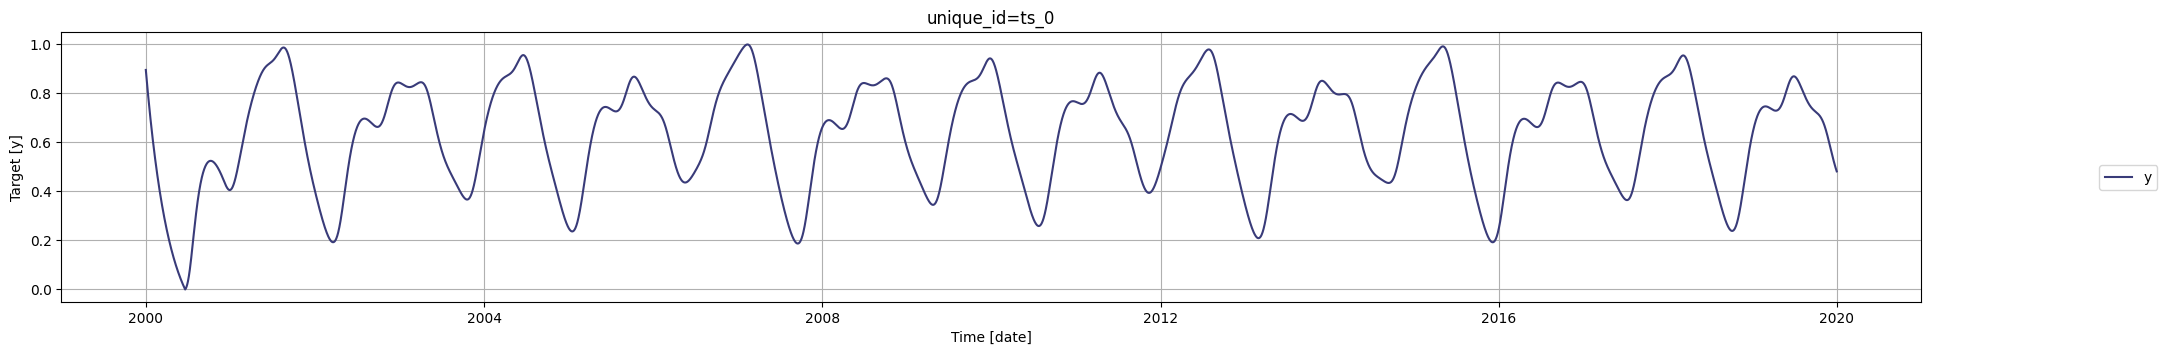

In [ ]:
timegpt.plot(mg_train,time_col = 'date', target_col='y')

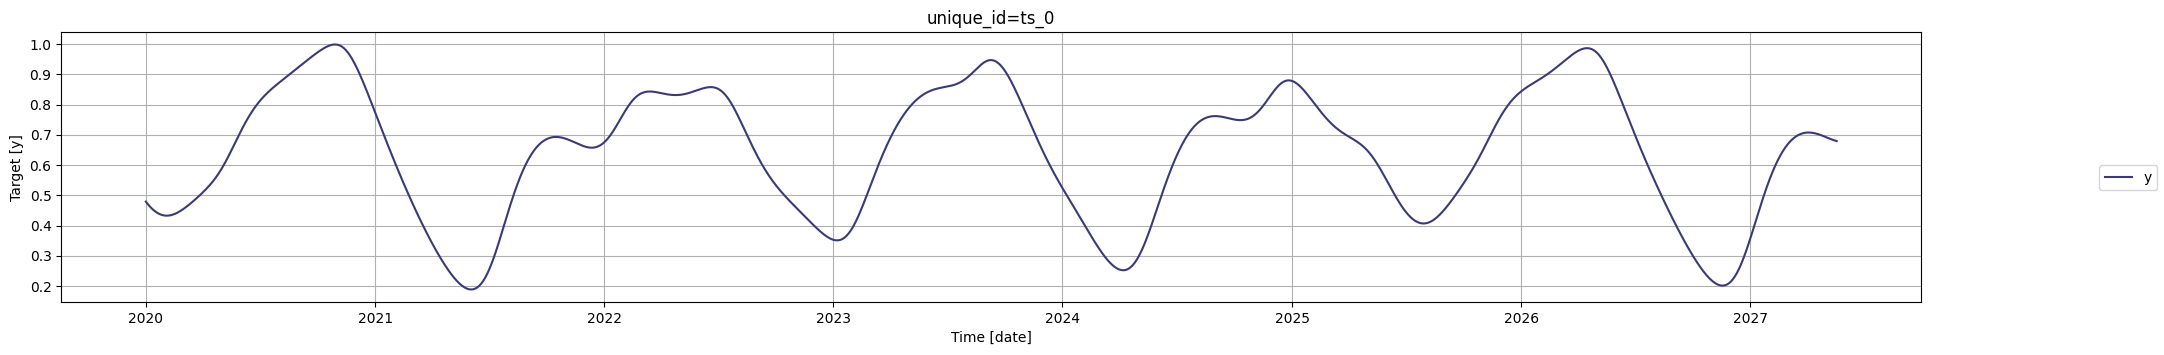

In [ ]:
timegpt.plot(mg_val,time_col = 'date', target_col='y')

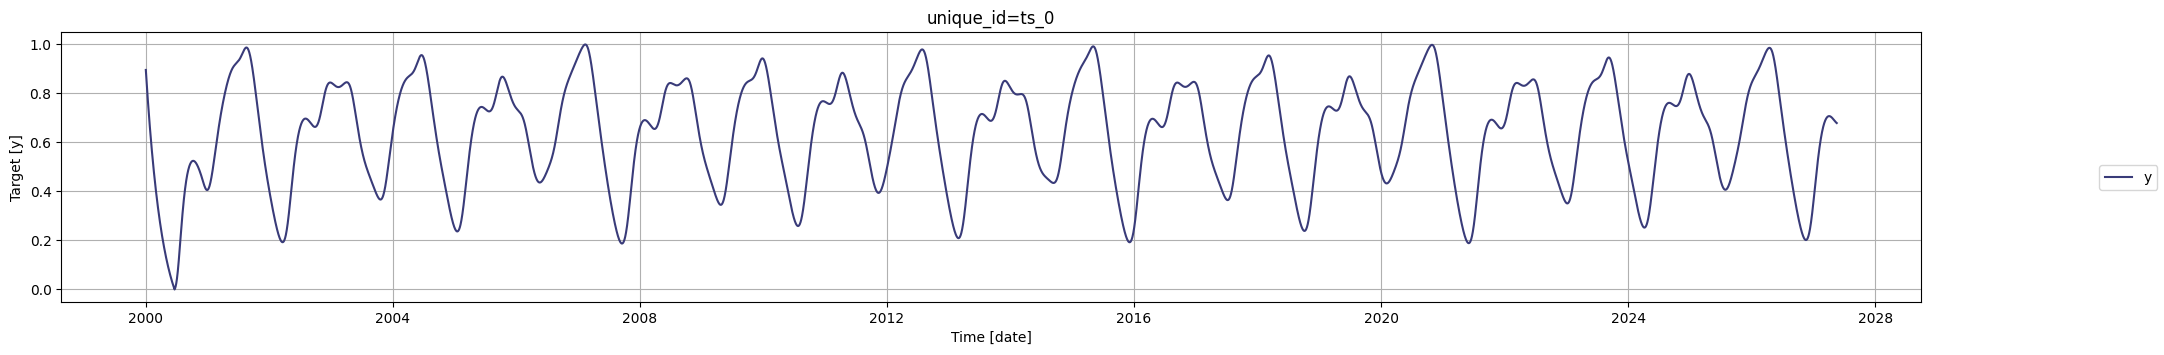

In [ ]:
timegpt.plot(mg,time_col = 'date', target_col='y')

#### short forecasting horizon

In [ ]:
def get_prediction_metrics(df, past, future, n_samples):
    results = []
    tests = []
    for i in range(n_samples):
        indx = random.randint(past, len(df)-future)
        timegpt_fcst_df = timegpt.forecast(df=df[indx:indx+past], h=future, finetune_steps=10, freq='1d', time_col='date', target_col='y')
        results.append(timegpt_fcst_df)
        tests.append(df[indx+past:indx+past+future])

    y = []
    y_hat = []
    for i in range(n_samples):
        y.append(tests[i]['y'].values[0])
        y_hat.append(results[i]['TimeGPT'].values[0])
    y = np.array(y)
    y_hat = np.array(y_hat)
    print('values for one step ahead prediction')
    # print('nrmse : ',n)
    print('mse : ', mean_squared_error(y_hat, y))
    print('mape : ', mean_absolute_percentage_error(y_hat, y))
    print('rmse : ',  math.sqrt(mean_squared_error(y_hat, y)))

In [ ]:
get_prediction_metrics(mg, 36, 1, 20)

values for one step ahead prediction
mse :  1.1268923545348178e-05
mape :  0.004782004452655972
rmse :  0.0033569217365539187


#### longer horizon

In [ ]:
timegpt_fcst_year_ahead = timegpt.forecast(df=mg_train, h=365, freq='1d', finetune_steps=50, time_col='date', target_col='y')
timegpt_fcst_year_ahead

,date,TimeGPT
0,2020-01-01,0.480215
1,2020-01-02,0.477032
2,2020-01-03,0.473452
3,2020-01-04,0.469532
4,2020-01-05,0.465342
...,...,...
360,2020-12-26,0.359864
361,2020-12-27,0.359863
362,2020-12-28,0.359862
363,2020-12-29,0.359859


<Axes: xlabel='date'>

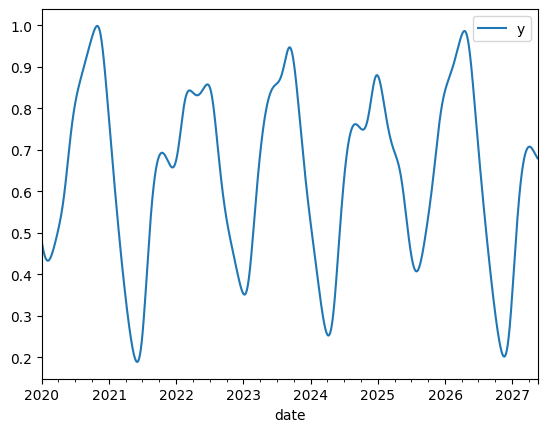

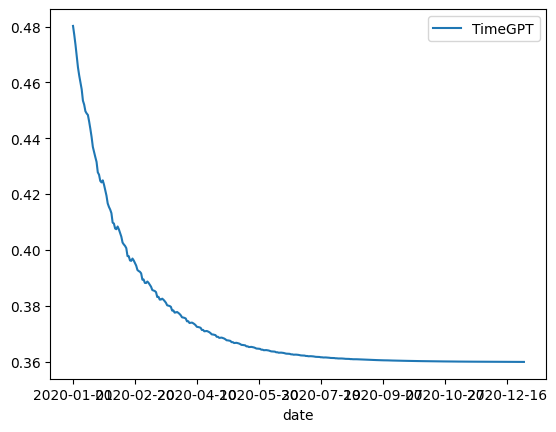

In [ ]:
mg_val.plot(x = 'date', y = 'y')
timegpt_fcst_year_ahead.plot(x = 'date', y = 'TimeGPT')

In [ ]:
get_prediction_metrics(mg, 100, 40, 20)

values for one step ahead prediction
mse :  1.9527565916717426e-05
mape :  0.004886704132250025
rmse :  0.004419000556315582


### electricity dataset

In [ ]:
import numpy as np

def prepare_electricity(electricity_df):
    electricity_df.rename(columns = {'Datetime':'date'}, inplace = True)
    electricity_df['y'] = electricity_df.groupby('date')['PJME_MW'].transform('sum')
    electricity_df['date'] = pd.to_datetime(electricity_df["date"], yearfirst = True)
    electricity_df.drop_duplicates(subset = ['date'], keep = 'first',inplace=True)
    # el.drop(columns = ['date', 'time'], inplace = True)
    electricity_df = electricity_df[electricity_df.date.dt.year>2010]
    'month', 'weekday', 'hour', 'year'
    electricity_df['year'] = electricity_df['date'].dt.year
    electricity_df['hour'] = electricity_df['date'].dt.hour
    electricity_df['month'] = electricity_df['date'].dt.month
    electricity_df['weekday'] = electricity_df['date'].dt.weekday
    electricity_df['unique_id'] = 1
    el_train = electricity_df[electricity_df.date.dt.year<2017]
    el_val = electricity_df[electricity_df.date.dt.year>=2017]

    columns_to_normalize = ['y']
    scaler = MinMaxScaler()
    el_train[columns_to_normalize] = scaler.fit_transform(el_train[columns_to_normalize].values)
    el_val[columns_to_normalize] = scaler.transform(el_val[columns_to_normalize].values)
    electricity_df[columns_to_normalize] = scaler.fit_transform(electricity_df[columns_to_normalize].values)
    el_train.index = np.arange(1, len(el_train) + 1)
    el_val.index = np.arange(1, len(el_val) + 1)
    return el_train, el_val, electricity_df

In [ ]:
el = pd.read_csv('PJME_hourly.csv')
el.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [ ]:
el_train, el_val, el = prepare_electricity(el)

In [ ]:
el_train.tail()

,date,PJME_MW,y,year,hour,month,weekday,unique_id
52595,2016-01-01 20:00:00,32530.0,0.381852,2016,20,1,4,1
52596,2016-01-01 21:00:00,32131.0,0.373381,2016,21,1,4,1
52597,2016-01-01 22:00:00,31318.0,0.356121,2016,22,1,4,1
52598,2016-01-01 23:00:00,29930.0,0.326653,2016,23,1,4,1
52599,2016-01-02 00:00:00,28315.0,0.292366,2016,0,1,5,1


In [ ]:
el_train = el_train.sort_values('date', axis = 0)
el_val = el_val.sort_values('date', axis = 0)

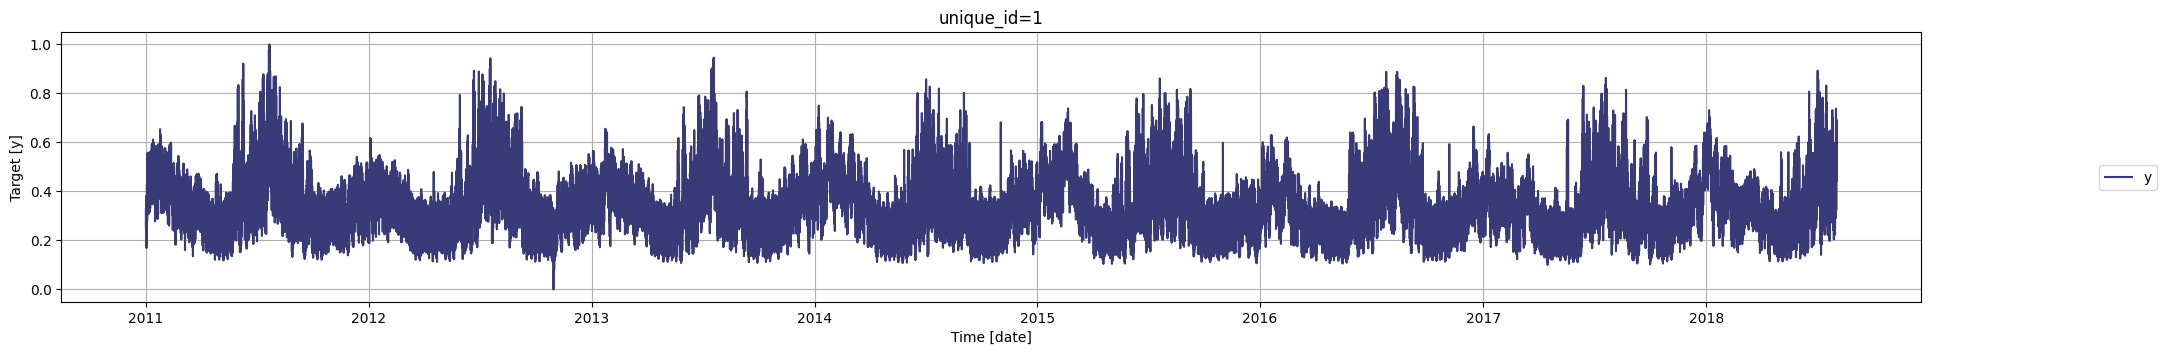

In [ ]:
timegpt.plot(el, time_col='date', target_col='y')

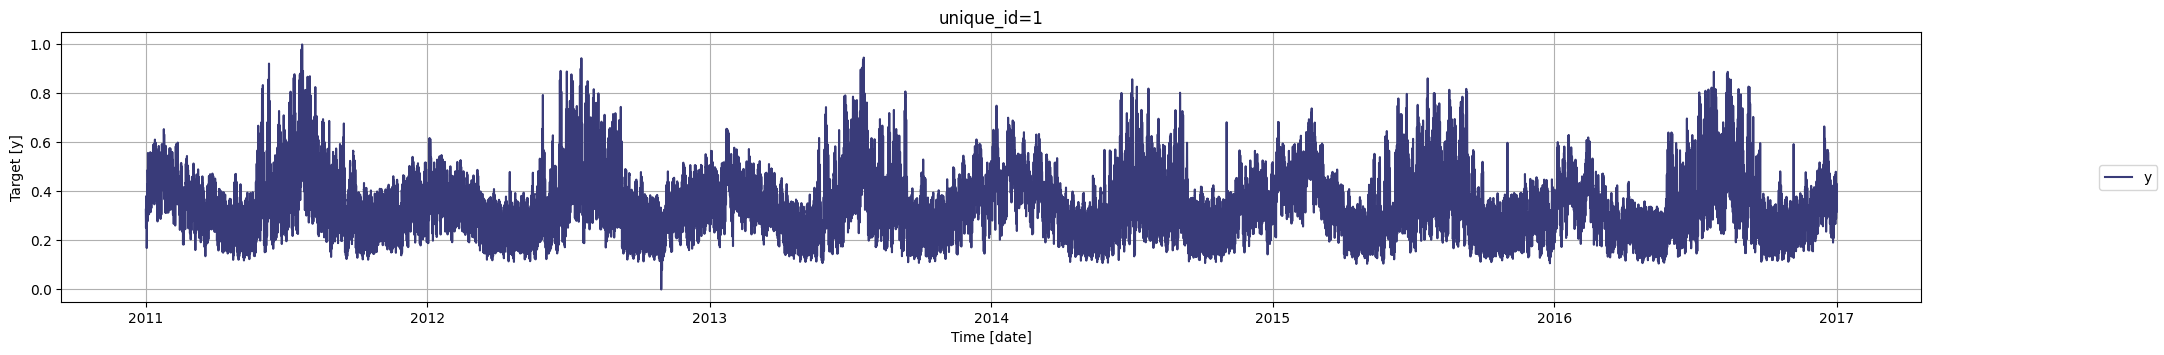

In [ ]:
timegpt.plot(el_train, time_col='date', target_col='y')

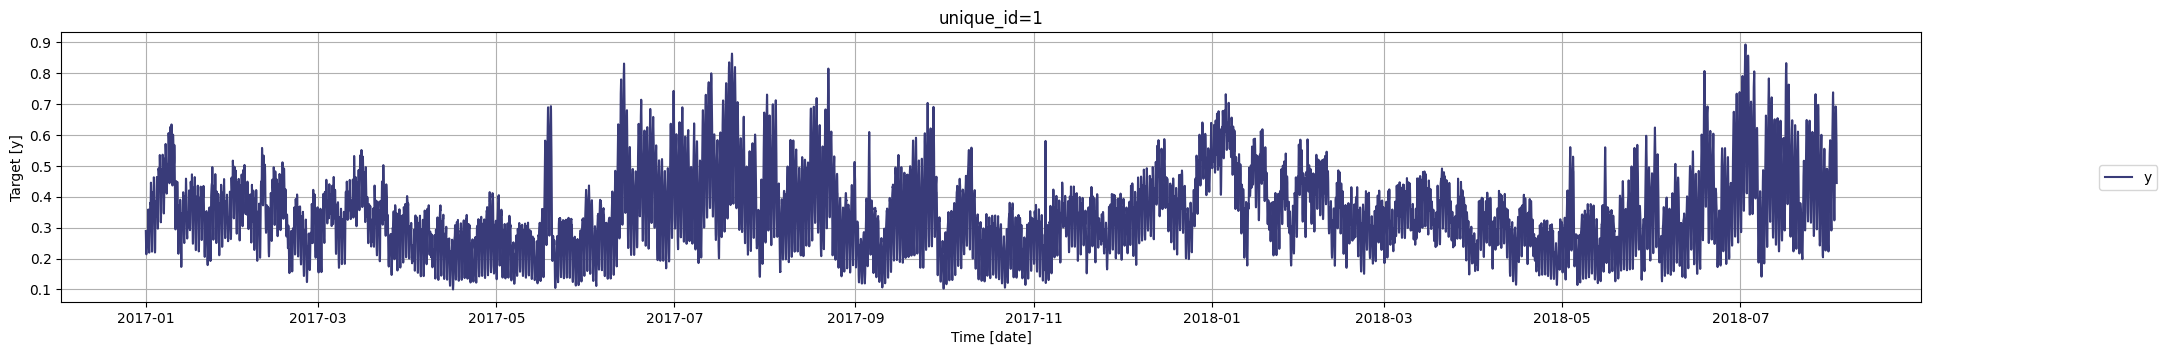

In [ ]:
timegpt.plot(el_val, time_col='date', target_col='y')

In [ ]:
train_values = el_train[['date', 'unique_id','y']]
train_exogenous = el_train[['date', 'unique_id', 'month', 'weekday', 'hour', 'year']]
val_exogenous = el_val[['date', 'unique_id', 'month', 'weekday', 'hour', 'year']]

In [ ]:
el_ex = el[['date', 'unique_id', 'month', 'weekday', 'hour', 'year']]

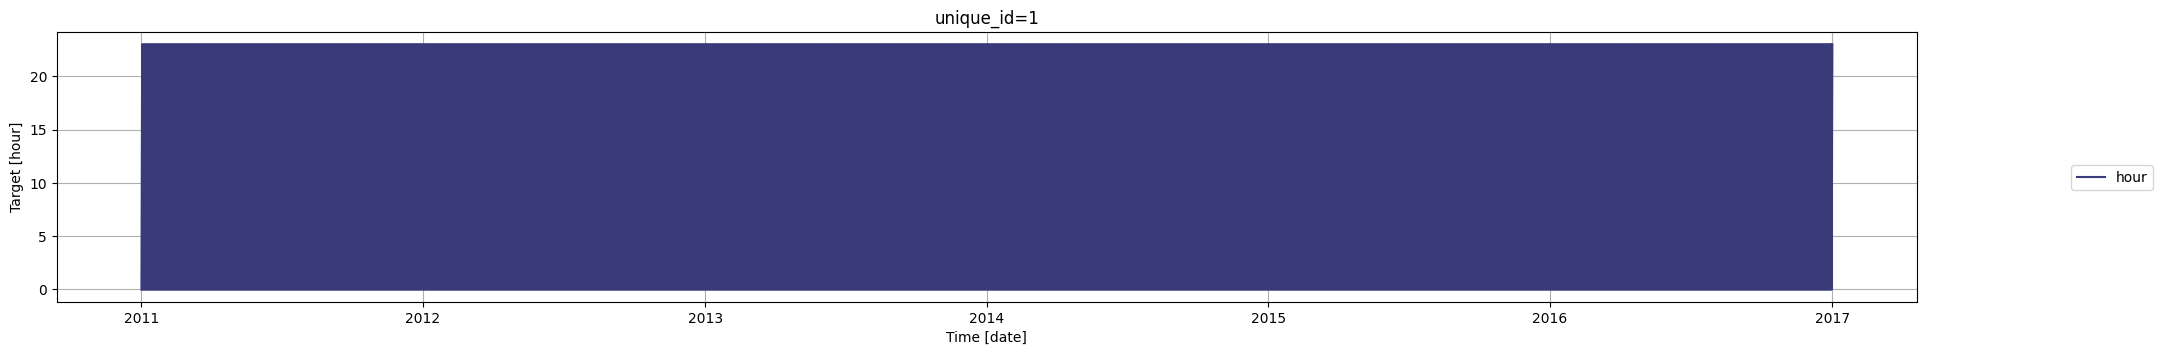

In [ ]:
timegpt.plot(train_exogenous, time_col='date', target_col='hour')

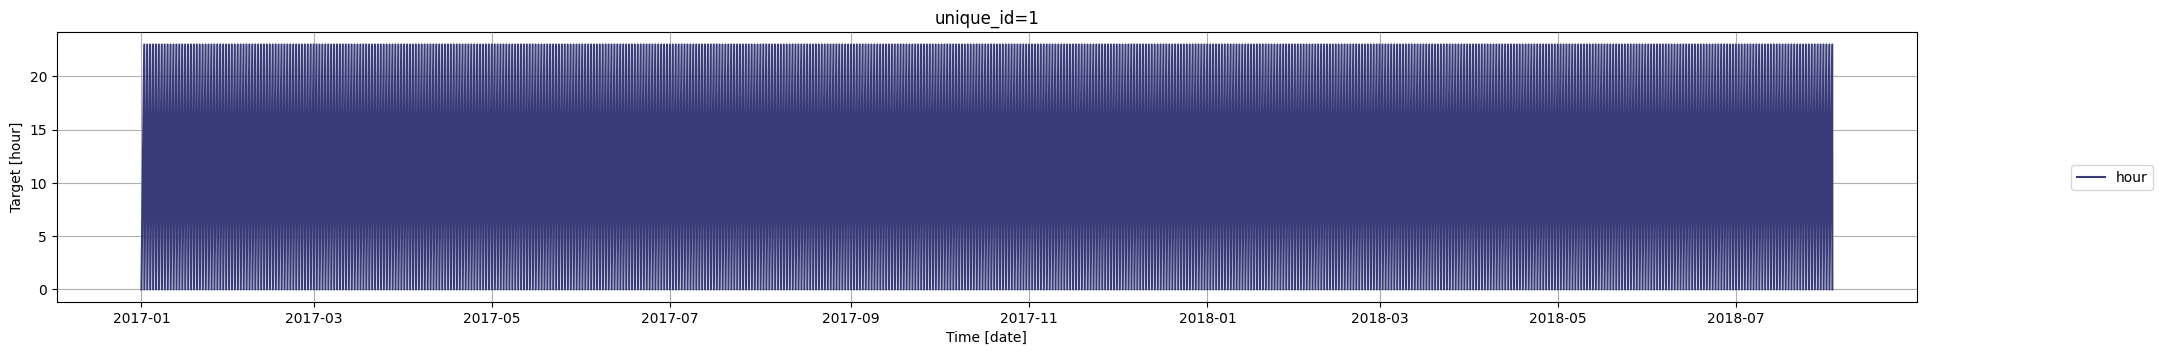

In [ ]:
timegpt.plot(val_exogenous, time_col='date', target_col = 'hour')

In [ ]:
train_exogenous.tail()

,date,unique_id,month,weekday,hour,year
43836,2016-12-31 19:00:00,1,12,5,19,2016
43837,2016-12-31 20:00:00,1,12,5,20,2016
43838,2016-12-31 21:00:00,1,12,5,21,2016
43839,2016-12-31 22:00:00,1,12,5,22,2016
43840,2016-12-31 23:00:00,1,12,5,23,2016


In [ ]:
val_exogenous.values.shape

(13895, 6)

In [ ]:
el = el.sort_values('date', axis = 0)

In [ ]:
el_ex = el_ex.sort_values('date', axis = 0)

In [ ]:
def get_prediction_metrics_with_exogenous(df, df_exogenous, past, future, freq, target_col, n_samples):
    results = []
    tests = []
    for i in range(n_samples):
        indx = random.randint(past, len(df)-future)
        if len(df_exogenous[indx+past:indx+past+future]) != future:
            continue
        timegpt_fcst_df = timegpt.forecast(df=df[indx:indx+past], h=future, X_df = df_exogenous[indx+past:indx+past+future], finetune_steps=10, freq=freq, time_col='date', target_col=target_col)
        results.append(timegpt_fcst_df)
        tests.append(df[indx+past:indx+past+future])
    y = []
    y_hat = []
    for i in range(len(tests)):
        y.append(tests[i][target_col].values[0])
        y_hat.append(results[i]['TimeGPT'].values[0])
    y = np.array(y)
    y_hat = np.array(y_hat)
    print('values for one step ahead prediction')
    # print('nrmse : ',n)
    print('mse : ', mean_squared_error(y_hat, y))
    print('mape : ', mean_absolute_percentage_error(y_hat, y))
    print('rmse : ',  math.sqrt(mean_squared_error(y_hat, y)))

In [ ]:
get_prediction_metrics_with_exogenous(el, el_ex, 36, 1, '1h', 'y',20)

values for one step ahead prediction
mse :  0.00132421748979437
mape :  0.13977491240181839
rmse :  0.03638979925465885


In [ ]:
get_prediction_metrics_with_exogenous(el, el_ex, 20*24, 7*24, '1h','y', 20)

values for one step ahead prediction
mse :  0.0006680767545858026
mape :  0.04378440087459494
rmse :  0.02584718078603163


In [ ]:
electricity_short = timegpt.forecast(df=el_train, time_col = 'date', freq = '1h', X_df=val_exogenous[:24], h=24, level=[80, 90])
electricity_short.head()

,unique_id,date,TimeGPT,TimeGPT-lo-90,TimeGPT-lo-80,TimeGPT-hi-80,TimeGPT-hi-90
0,1,2017-01-01 00:00:00,0.289038,0.239093,0.243348,0.334727,0.338982
1,1,2017-01-01 01:00:00,0.261190,0.166608,0.177232,0.345148,0.355773
2,1,2017-01-01 02:00:00,0.247239,0.122710,0.144780,0.349699,0.371769
3,1,2017-01-01 03:00:00,0.240985,0.099779,0.128742,0.353228,0.382191
4,1,2017-01-01 04:00:00,0.242836,0.092368,0.125642,0.360029,0.393303


<Axes: xlabel='date'>

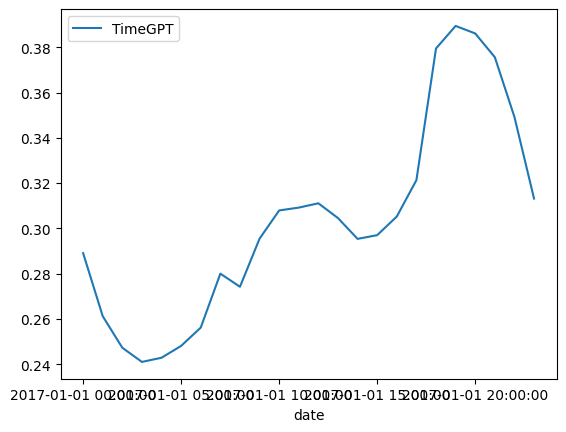

In [ ]:
electricity_short.plot(x = 'date', y = 'TimeGPT')

<Axes: xlabel='date'>

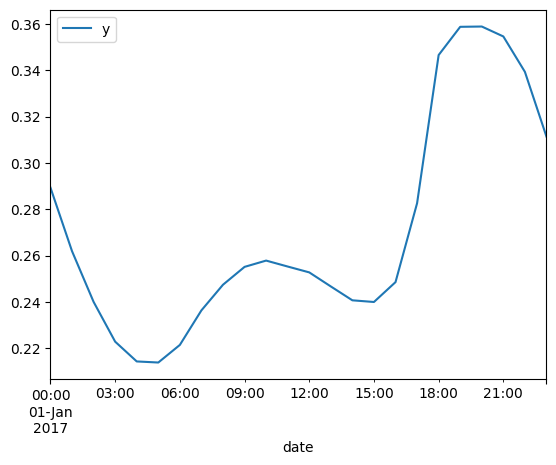

In [ ]:
el_val[:24].plot(x = 'date', y= 'y')

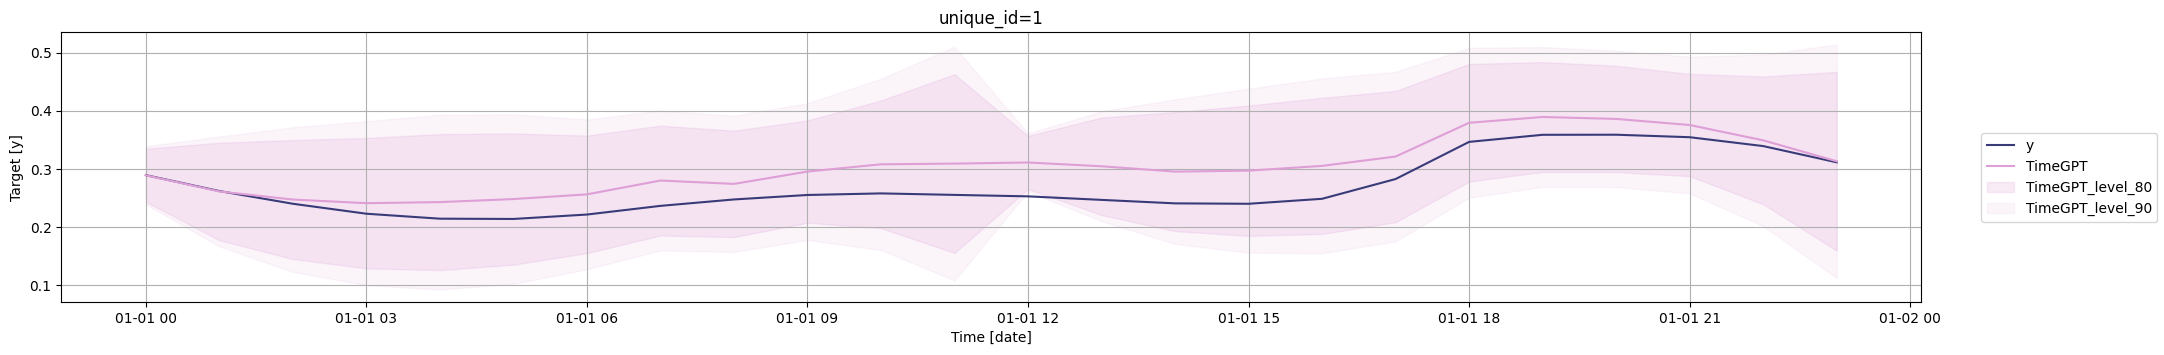

In [ ]:
timegpt.plot(
    el_val[['unique_id', 'date', 'y']][:24],
    electricity_short,
    max_insample_length=365*10,
    level=[80, 90],
    time_col = 'date',
    target_col = 'y',
)


In [ ]:
import math

print('values for one step ahead prediction')
# print('nrmse : ',n)
print('mse : ', mean_squared_error(el_val[:24].y, electricity_short['TimeGPT']))
print('mape : ', mean_absolute_percentage_error(el_val[:24].y, electricity_short['TimeGPT']))
print('rmse : ',  math.sqrt(mean_squared_error(el_val[:24].y, electricity_short['TimeGPT'])))

values for one step ahead prediction
mse :  0.0014273483286078158
mape :  0.12783881646147585
rmse :  0.03778026374455075


#### longer range prediction

In [ ]:
electricity_long = timegpt.forecast(df=el_train, time_col = 'date', freq = '1h', X_df=val_exogenous[:7*24], h=24*7, level=[80, 90])
electricity_long.head()

,unique_id,date,TimeGPT,TimeGPT-lo-90,TimeGPT-lo-80,TimeGPT-hi-80,TimeGPT-hi-90
0,1,2017-01-01 00:00:00,0.289038,0.239093,0.243348,0.334727,0.338982
1,1,2017-01-01 01:00:00,0.261190,0.166608,0.177232,0.345148,0.355773
2,1,2017-01-01 02:00:00,0.247239,0.122710,0.144780,0.349699,0.371769
3,1,2017-01-01 03:00:00,0.240985,0.099779,0.128742,0.353228,0.382191
4,1,2017-01-01 04:00:00,0.242836,0.092368,0.125642,0.360029,0.393303


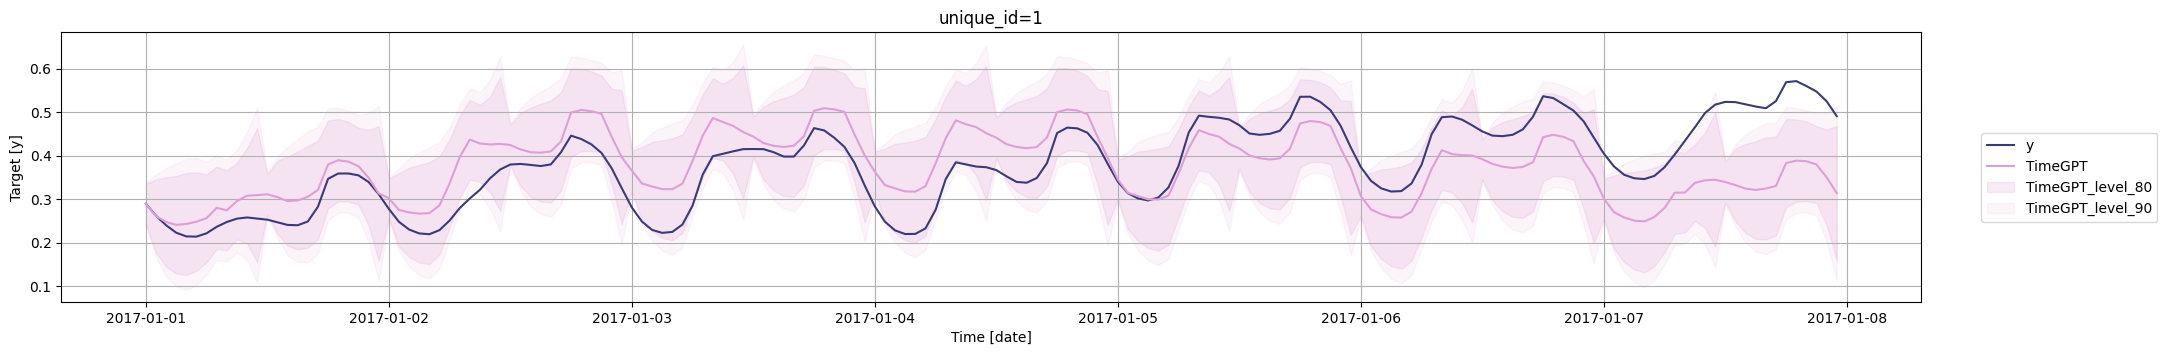

In [ ]:
timegpt.plot(
    el_val[['unique_id', 'date', 'y']][:7*24],
    electricity_long,
    max_insample_length=365*10,
    level=[80, 90],
    time_col = 'date',
    target_col = 'y',
)


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_percentage_error
# from sklearn.metrics import root_mean_squared_error
import math

print('values for one step ahead prediction')
# print('nrmse : ',n)
print('mse : ', mean_squared_error(el_val[:7*24].y, electricity_long['TimeGPT']))
print('mape : ', mean_absolute_percentage_error(el_val[:7*24].y, electricity_long['TimeGPT']))
print('rmse : ',  math.sqrt(mean_squared_error(el_val[:7*24].y, electricity_long['TimeGPT'])))

values for one step ahead prediction
mse :  0.0068559280230576355
mape :  0.18850841125997303
rmse :  0.082800531538497


<Axes: xlabel='date'>

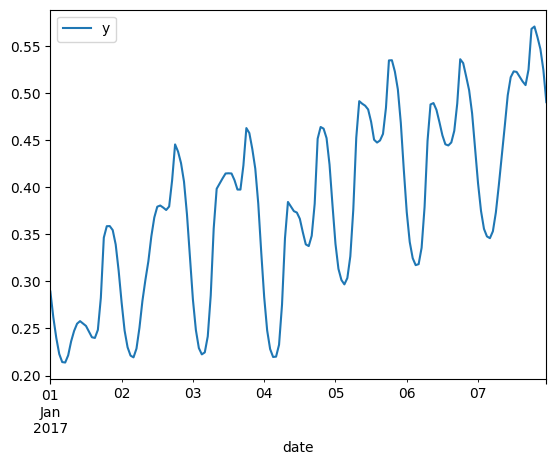

In [ ]:
el_val[:7*24].plot(x = 'date', y= 'y')

<Axes: xlabel='date'>

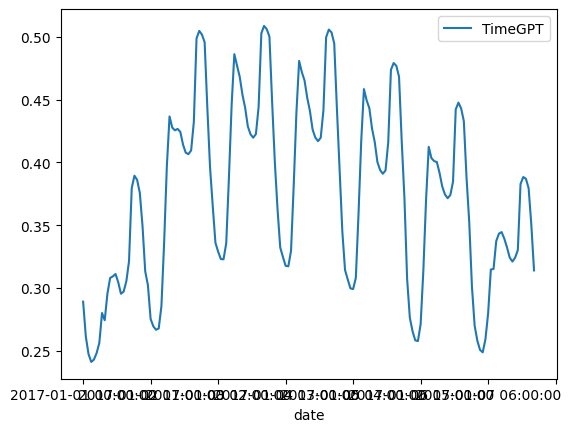

In [ ]:
electricity_long.plot(x = 'date', y = 'TimeGPT')

### Budapest dataset

In [ ]:
def prepare_chick(chick):
    chick['date'] = pd.to_datetime(chick["Date"], dayfirst = True)
    chick.drop_duplicates(subset = ['date'],inplace=True)
    chick.drop(columns = ['Date'], inplace = True)

    chick['year'] = chick['date'].dt.year
    chick['month'] = chick['date'].dt.month
    chick['unique_id'] = 1
    chick = chick[chick.date.dt.year>=2008]
    chick_train, chick_val = chick[chick.date.dt.year<=2013], chick[chick.date.dt.year>2013]

    columns_to_normalize = ['BUDAPEST']
    scaler = MinMaxScaler()
    chick_train[columns_to_normalize] = scaler.fit_transform(chick_train[columns_to_normalize].values)
    chick_val[columns_to_normalize] = scaler.transform(chick_val[columns_to_normalize].values)
    chick[columns_to_normalize] = scaler.fit_transform(chick[columns_to_normalize].values)
    chick_train.index = np.arange(1, len(chick_train) + 1)
    chick_val.index = np.arange(1, len(chick_val) + 1)
    return chick_train, chick_val, chick

In [ ]:
chick_df = pd.read_csv('hungary_chickenpox.csv')

In [ ]:
chick_train, chick_val, chick = prepare_chick(chick_df)

<ipython-input-158-b1e825ae5fd2>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chick_train[columns_to_normalize] = scaler.fit_transform(chick_train[columns_to_normalize].values)
<ipython-input-158-b1e825ae5fd2>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chick_val[columns_to_normalize] = scaler.transform(chick_val[columns_to_normalize].values)
<ipython-input-158-b1e825ae5fd2>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

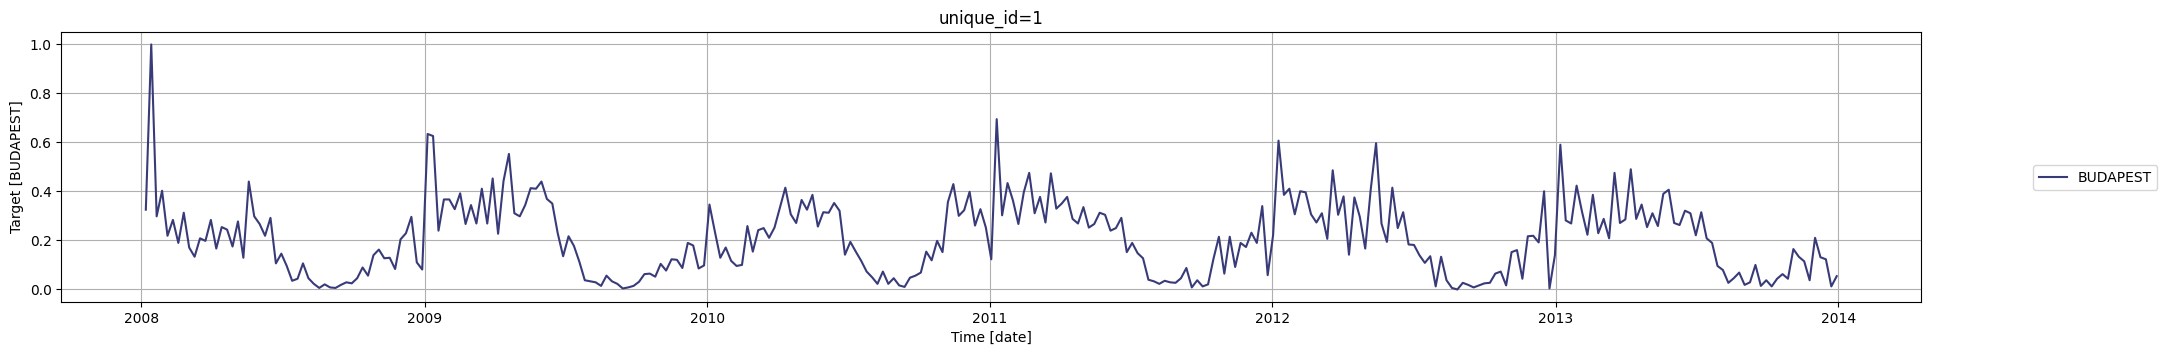

In [ ]:
timegpt.plot(chick_train, time_col='date', target_col='BUDAPEST')

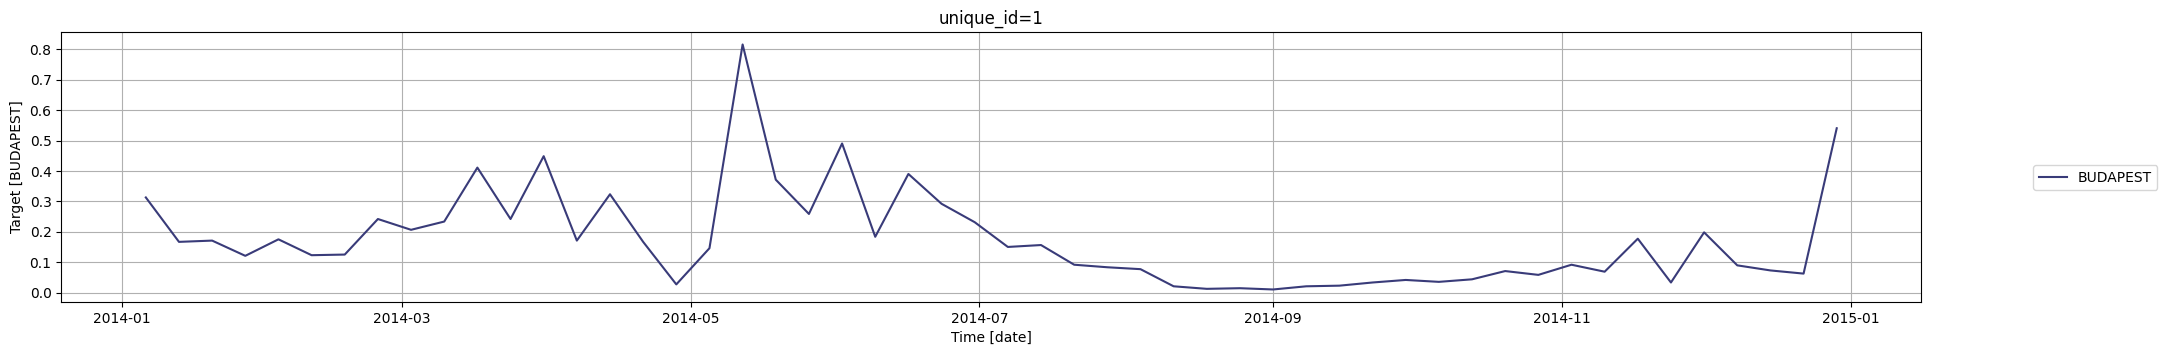

In [ ]:
timegpt.plot(chick_val, time_col='date', target_col='BUDAPEST')

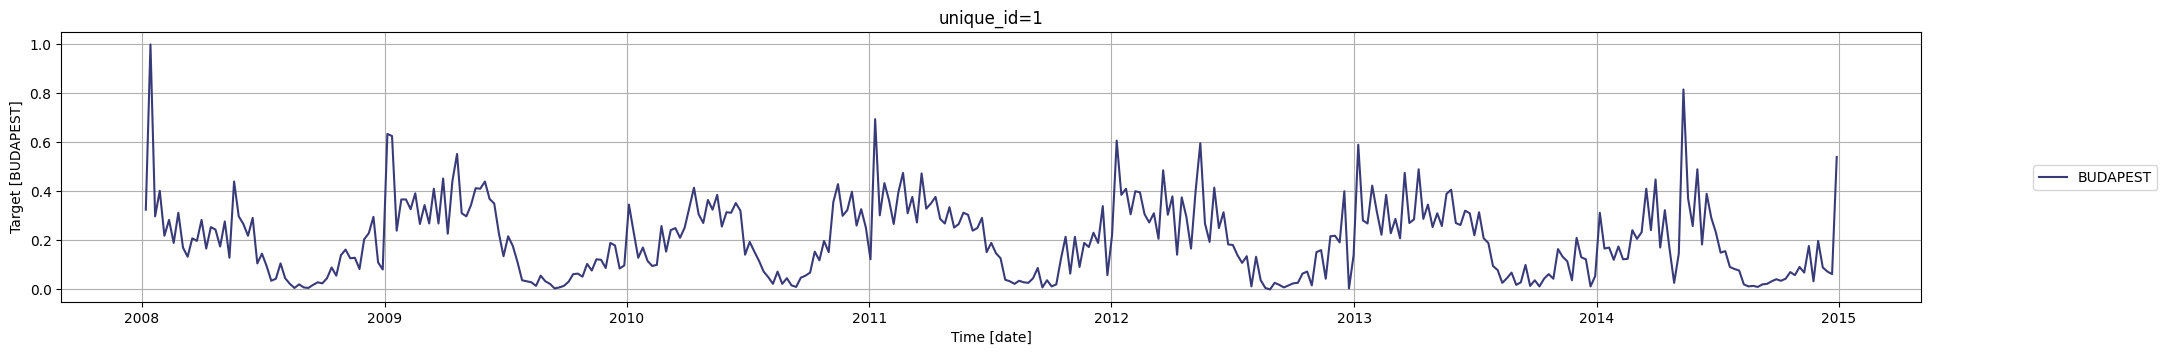

In [ ]:
timegpt.plot(chick, time_col='date', target_col='BUDAPEST')

In [ ]:
chick_exogenous = chick[['date', 'unique_id', 'month', 'year']]

In [ ]:
chick = chick.sort_values(by = 'date', axis =0 )

In [ ]:
chick_exogenous[chick_exogenous['date']=='2010-05-10']

,date,unique_id,month,year
279,2010-05-10,1,5,2010


In [ ]:
chick_exogenous = chick_exogenous.sort_values(by = 'date', axis = 0)

In [ ]:
get_prediction_metrics_with_exogenous(chick, chick_exogenous, 36, 1, '7d', 'BUDAPEST',20)

values for one step ahead prediction
mse :  0.026465862184741534
mape :  1.264059961539078
rmse :  0.16268331870459718


In [ ]:
get_prediction_metrics_with_exogenous(chick, chick_exogenous, 36, 8, '7d', 'BUDAPEST',20)

values for one step ahead prediction
mse :  0.013099894593342385
mape :  2.2918641609256207
rmse :  0.1144547709505479


#### Short range prediction

In [ ]:
train_values = chick_train[['date', 'unique_id','BUDAPEST']]
train_exogenous = chick_train[['date', 'unique_id', 'month', 'year']]
val_exogenous = chick_val[['date', 'unique_id', 'month', 'year']]
train_exogenous = chick_train[['date', 'unique_id', 'month', 'year']]

In [ ]:
chick_short = timegpt.forecast(df=chick_train, finetune_steps=15, target_col = 'BUDAPEST', time_col = 'date', freq = '7d', X_df=val_exogenous[:1], h=1, level=[80, 90])
chick_short.head()

In [ ]:
chick_val[:1]['BUDAPEST']

In [ ]:
print('values for one step ahead prediction')
# print('nrmse : ',n)
print('mse : ', mean_squared_error(chick_val[:1].BUDAPEST, chick_short['TimeGPT']))
print('mape : ', mean_absolute_percentage_error(chick_val[:1].BUDAPEST, chick_short['TimeGPT']))
print('rmse : ',  math.sqrt(mean_squared_error(chick_val[:1].BUDAPEST, chick_short['TimeGPT'])))

In [ ]:
timegpt.plot(
    chick_val[['unique_id', 'date', 'BUDAPEST']],
    chick_short,
    max_insample_length=365,
    level=[80, 90],
    time_col = 'date',
    target_col = 'BUDAPEST',
)


#### longer range prediction

In [ ]:
chick_train[:80]

In [ ]:
train_exogenous[80:87]

In [ ]:
chick_long = timegpt.forecast(df=chick_train,finetune_steps=15, target_col = 'BUDAPEST', time_col = 'date', freq = '7d', X_df=val_exogenous[:7], h=7, level=[80, 90])
chick_long.head()

In [ ]:
chick_val[:7]['BUDAPEST']

In [ ]:
timegpt.plot(
    chick_val[['unique_id', 'date', 'BUDAPEST']],
    chick_long,
    max_insample_length=365,
    level=[80, 90],
    time_col = 'date',
    target_col = 'BUDAPEST',
)
